# Dataset: IMDB movies

## Dataset: 
IMDB movies
## Download: 
https://www.kaggle.com/rounakbanik/the-movies-dataset?select=tings.csv
## Goal: 
A new movie streaming company has launched a competition and the winning company gets the contract. They want their own English movie recommendation system and your task is to create a POC of this system. They want you to recommend ten movies for each user to watch next and predict how would they rate these movies (the latter is not applicable for apriori, eclat and Markov chains). For apriori, eclat and Markov chains state the probabilities of each rule/transition.
## Description: 
These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.
This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.
## Technologies: 
Apriori, Eclat, Markov chains, Surprise, SVD, vector spaces.

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import ast 
import surprise

from apyori import apriori
from recommenders.utils.timer import Timer
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# Load the datasets
meta = pd.read_csv('movies_metadata.csv', low_memory=False)
links= pd.read_csv('links_small.csv')
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
ratings = pd.read_csv('ratings_small.csv')

### Metadata

In [3]:
# Show the metadata df
meta.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
# Show the information about metadata df
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [5]:
# Show the descriptive stats for meta df
meta.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


### Links

In [6]:
# Show the links df
links.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [7]:
# Get information about links df
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9125 non-null   int64  
 1   imdbId   9125 non-null   int64  
 2   tmdbId   9112 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 214.0 KB


Since this table contains only IMDB ID and TMBD ID we may not use it

### Credits

In [8]:
# Show the credits df
credits.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [9]:
# Get the information about credits df
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


### Keywords

In [10]:
# Show the keywords df
keywords.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [11]:
# Get information about keywords df
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


### Ratings

In [12]:
# Show the ratings df
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [13]:
# Get information about ratings
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


## Data Cleaning

### Metadata

#### Adult

In [14]:
# Check values in the adult column
meta.adult.value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [15]:
# Keep only rows where adult is True or False
meta = meta.loc[meta.adult.isin(['True','False']), :]

In [16]:
# Change values from true, false to 1, 0
meta.adult = meta.adult.map({'True': 1, 'False': 0})

In [17]:
meta

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,0,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,0,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,0,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,0,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,0,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,0,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,0,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


#### Belongs to collection

In [18]:
# Show 5 values from belongs to collection column
meta.belongs_to_collection.values[:5]

array(["{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}",
       nan,
       "{'id': 119050, 'name': 'Grumpy Old Men Collection', 'poster_path': '/nLvUdqgPgm3F85NMCii9gVFUcet.jpg', 'backdrop_path': '/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg'}",
       nan,
       "{'id': 96871, 'name': 'Father of the Bride Collection', 'poster_path': '/nts4iOmNnq7GNicycMJ9pSAn204.jpg', 'backdrop_path': '/7qwE57OVZmMJChBpLEbJEmzUydk.jpg'}"],
      dtype=object)

In [19]:
# To convert string to dictionary
ast.literal_eval(meta.belongs_to_collection.values[0])

{'id': 10194,
 'name': 'Toy Story Collection',
 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg',
 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}

We are going to keep the name in the collection column if the value is not na

In [20]:
# Create a new column for the collection name
meta['collectionName'] = ""

# Iterate through the belongs_to_collection column and populate the collectionName column
for i, val in enumerate(meta['belongs_to_collection']):
    if pd.isnull(val):
        meta.at[i, 'collectionName'] = "No Collection"
    else:
        meta.at[i, 'collectionName'] = ast.literal_eval(val)['name']

# Drop the belongs_to_collection column
meta = meta.drop(columns=['belongs_to_collection'])

In [21]:
# Show some of the values from the collectionName column
meta['collectionName'].values

array(['Toy Story Collection', 'No Collection',
       'Grumpy Old Men Collection', ..., 'No Collection', 'No Collection',
       'No Collection'], dtype=object)

## Budget

In [22]:
# Show descriptive stats of budget column
meta.budget.describe()

count     45463
unique     1223
top           0
freq      36573
Name: budget, dtype: object

In [23]:
# Calculate the percentage of missing values in the budget column
pct_missing = (meta.budget == 0).mean() * 100
print(f"Percentage of missing values: {pct_missing:.2f}%")

Percentage of missing values: 0.00%


In [24]:
(sum(meta.budget == 0)/meta.shape[0])*100

0.0

Since there are 80 percent of missing data in this column we are going to drop this data

In [25]:
# Drop the budget column since more than 80% of the values are missing
meta = meta.drop(columns = ['budget'])

## Genres

In [26]:
# Print the first 5 value of the genres column
print(meta.genres.values[:5])

["[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"
 "[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]"
 "[{'id': 10749, 'name': 'Romance'}, {'id': 35, 'name': 'Comedy'}]"
 "[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]"
 "[{'id': 35, 'name': 'Comedy'}]"]


In [27]:
# Convert the first value of the genres column to a list of dictionaries
genres_list = ast.literal_eval(meta.genres.values[0])
print(genres_list)

[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]


In [28]:
# Check the null values in the genres column
meta['genres'].isnull().sum()

3

In [29]:
# Remove the null values
meta = meta.dropna(subset=["genres"])

In [30]:
# Create a set to store all unique genres
unique_genres = set()

# Iterate through the genres column and add all unique genres to the set
for i in meta.genres:
    genres_list = ast.literal_eval(i)
    for j in genres_list:
        unique_genres.add(j["name"])

In [31]:
# Convert the set of unique genres to a list
genres = list(unique_genres)
print(genres)

['Thriller', 'TV Movie', 'Adventure', 'History', 'Horror', 'Fantasy', 'Comedy', 'Music', 'Western', 'Foreign', 'Animation', 'Crime', 'Family', 'War', 'Action', 'Mystery', 'Drama', 'Romance', 'Science Fiction', 'Documentary']


In [32]:
# Create an empty list to store the genre data for each movie
rows = []

# Iterate through the genres column and create a list of 1s and 0s for each movie
for i in meta.genres:
    genres_list = ast.literal_eval(i)
    movie_genres = [x['name'] for x in genres_list]
    row = []
    for j in genres:
        row.append(int(j in movie_genres))
    rows.append(row)

In [33]:
# Create a new DataFrame from the genre data
genre_df = pd.DataFrame(rows, columns=genres)
genre_df

,Thriller,TV Movie,Adventure,History,Horror,Fantasy,Comedy,Music,Western,Foreign,Animation,Crime,Family,War,Action,Mystery,Drama,Romance,Science Fiction,Documentary
0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45458,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
45459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
45460,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
45461,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# Concatenate the genre DataFrame with the original DataFrame
meta = pd.concat([meta, genre_df], axis=1)

# Drop the original genres column
meta = meta.drop(columns=['genres'])

In [35]:
# Show the meta df
meta

,adult,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,...,Animation,Crime,Family,War,Action,Mystery,Drama,Romance,Science Fiction,Documentary
0,0.0,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]",...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45464,0.0,NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",0.003503,/aorBPO7ak8e8iJKT5OcqYxU3jlK.jpg,"[{'name': 'Yermoliev', 'id': 88753}]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45465,0.0,NaN,461257,tt6980792,en,Queerama,50 years after decriminalisation of homosexual...,0.163015,/s5UkZt6NTsrS7ZF0Rh8nzupRlIU.jpg,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
29503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Homepage

In [36]:
# Dropping homepage column since it is not needed
meta = meta.drop(columns=["homepage"])

## ID & IMDB ID

In [37]:
# Check the number of unique Id's
(meta.shape[0]) - len(meta.id.unique())

32

In [38]:
# Check not unique values in imdb_id
meta.shape[0] - len(meta.imdb_id.unique())

49

In [39]:
# Remove duplicates in ID and imdb_id columns
meta.drop_duplicates(subset=["id", "imdb_id"], inplace=True)

In [40]:
# Drop missing values from ID and imdb_id columns
meta.dropna(subset=["id", "imdb_id"], inplace=True)

In [41]:
# Change type of ID to int64
meta["id"] = meta["id"].astype("int64")

## Original Language & Title & Overview

In [42]:
#check how many possible values in the original language column
meta.original_language.value_counts()

en    32238
fr     2435
it     1529
ja     1346
de     1079
      ...  
ay        1
rw        1
cy        1
tg        1
si        1
Name: original_language, Length: 89, dtype: int64

In [43]:
# Check for missing values in original_language and title columns
print(meta.original_language.isnull().sum())
print(meta.title.isnull().sum())

11
3


In [44]:
# Drop rows with missing values in original_language and title columns
meta.dropna(subset=["original_language", "title"], inplace=True)

In [45]:
# Transform overview to lowercase and remove leading/trailing whitespace
meta.overview = meta.overview.str.lower().str.strip()

In [46]:
# Replace missing values in overview column with a default string
meta.loc[meta.overview.isnull(), "overview"] = "no overview available"

## Popularity

In [47]:
# Get the type of popularity column
meta.popularity.dtype

dtype('O')

In [48]:
# Change type of popularity column to float64
meta.popularity = meta.popularity.astype("float64")

## Poster Path

In [49]:
# Drop poster_path column
meta = meta.drop(columns=["poster_path"])

## Production companies and countries

In [50]:
# Get values of the  production companies
meta.production_companies.values

array(["[{'name': 'Pixar Animation Studios', 'id': 3}]",
       "[{'name': 'TriStar Pictures', 'id': 559}, {'name': 'Teitler Film', 'id': 2550}, {'name': 'Interscope Communications', 'id': 10201}]",
       "[{'name': 'Warner Bros.', 'id': 6194}, {'name': 'Lancaster Gate', 'id': 19464}]",
       ..., "[{'name': 'American World Pictures', 'id': 6165}]",
       "[{'name': 'Yermoliev', 'id': 88753}]", '[]'], dtype=object)

In [51]:
# Count missing values
meta.production_companies.isnull().sum()

0

In [52]:
# Extract and process production company names
import ast
index = 0
prod1 = []

for prod in meta.production_companies.values:
    prod_list = ast.literal_eval(prod)
    if len(prod_list) > index:
        prod1.append(prod_list[index]["name"])
    else:
        prod1.append("No Producer")

meta["Producer1"] = prod1

In [53]:
index = 1
prod2 = []

for prod in meta.production_companies.values:
    prod_list = ast.literal_eval(prod)
    if len(prod_list) > index:
        prod2.append(prod_list[index]["name"])
    else:
        prod2.append("No Producer")

meta["Producer2"] = prod2

meta.drop(columns=["production_companies"], inplace=True)

In [54]:
# To lowercase and remove spacing
meta["Producer1"] = meta["Producer1"].str.lower().str.strip()
meta["Producer2"] = meta["Producer2"].str.lower().str.strip()

## Vote count and Vote average

In [55]:
# Check for missing values in vote_count and vote_average columns
print(meta.vote_count.isnull().sum())
print(meta.vote_average.isnull().sum())

0
0


In [56]:
# Show descriptive stats of the vote counts
meta.vote_count.describe()

count    45402.000000
mean       110.000000
std        491.611018
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [57]:
# Check the null values 
meta.vote_average.isnull().sum()

0

In [58]:
# Show descriptive stats of the vote average
meta.vote_average.describe()

count    45402.000000
mean         5.619479
std          1.922535
min          0.000000
25%          5.000000
50%          6.000000
75%          6.800000
max         10.000000
Name: vote_average, dtype: float64

## Release dates

In [59]:
# Check the type of the release date column
meta.release_date.dtype

dtype('O')

In [60]:
# Check the missing values
meta.release_date.isnull().sum()

81

In [61]:
# Drop rows with missing values in release_date column
meta.dropna(subset=["release_date"], inplace=True)

In [62]:
# Change release_date column to datetime type
meta.release_date = pd.to_datetime(meta.release_date, format="%Y-%m-%d")

## Runtime

In [63]:
# Check the missing values
meta.runtime.isnull().sum()

244

In [64]:
# Fill missing values in runtime column with median
meta.runtime.fillna(meta.runtime.median(), inplace=True)

In [65]:
# Get the number of rows where runtime is equal to zero
sum(meta.runtime == 0)

1531

In [66]:
# Replace rows with 0 runtime with median value
meta.loc[meta.runtime == 0, "runtime"] = 95

#### Revenue

In [67]:
# Get descriptive stats about the revenue column
meta.revenue.describe()

count    4.532100e+04
mean     1.123985e+07
std      6.442712e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.787965e+09
Name: revenue, dtype: float64

In [68]:
# Check the percent of missing values
(sum(meta.revenue == 0)*100)/(meta.shape[0])

83.67864786743452

In [69]:
# Drop revenue column
meta = meta.drop(columns=["revenue"])

## Spoken languages

In [70]:
#Get 5 values of the column
meta.spoken_languages.values[:5]

array(["[{'iso_639_1': 'en', 'name': 'English'}]",
       "[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'fr', 'name': 'Français'}]",
       "[{'iso_639_1': 'en', 'name': 'English'}]",
       "[{'iso_639_1': 'en', 'name': 'English'}]",
       "[{'iso_639_1': 'en', 'name': 'English'}]"], dtype=object)

In [71]:
# Transform to a dict
ast.literal_eval(meta.spoken_languages.values[5])

[{'iso_639_1': 'en', 'name': 'English'},
 {'iso_639_1': 'es', 'name': 'Español'}]

In [72]:
# Extract total number of spoken languages
total_languages = []

for languages in meta.spoken_languages.values:
    language_list = ast.literal_eval(languages)
    total_languages.append(len(language_list))

meta["TotalLanguages"] = total_languages

In [73]:
meta

,adult,id,imdb_id,original_language,original_title,overview,popularity,production_countries,release_date,runtime,...,War,Action,Mystery,Drama,Romance,Science Fiction,Documentary,Producer1,Producer2,TotalLanguages
0,0.0,862,tt0114709,en,Toy Story,"led by woody, andy's toys live happily in his ...",21.946943,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pixar animation studios,no producer,1
1,0.0,8844,tt0113497,en,Jumanji,when siblings judy and peter discover an encha...,17.015539,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tristar pictures,teitler film,2
2,0.0,15602,tt0113228,en,Grumpier Old Men,a family wedding reignites the ancient feud be...,11.712900,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,101.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,warner bros.,lancaster gate,1
3,0.0,31357,tt0114885,en,Waiting to Exhale,"cheated on, mistreated and stepped on, the wom...",3.859495,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,127.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,twentieth century fox film corporation,no producer,1
4,0.0,11862,tt0113041,en,Father of the Bride Part II,just when george banks has recovered from his ...,8.387519,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sandollar productions,touchstone pictures,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45460,0.0,30840,tt0102797,en,Robin Hood,"yet another version of the classic epic, with ...",5.683753,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1991-05-13,104.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,westdeutscher rundfunk (wdr),working title films,1
45462,0.0,111109,tt2028550,tl,Siglo ng Pagluluwal,an artist struggles to finish his work while a...,0.178241,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,360.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sine olivia,no producer,1
45463,0.0,67758,tt0303758,en,Betrayal,"when one of her hits goes wrong, a professiona...",0.903007,"[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,american world pictures,no producer,1
45464,0.0,227506,tt0008536,en,Satana likuyushchiy,"in a small town live two brothers, one a minis...",0.003503,"[{'iso_3166_1': 'RU', 'name': 'Russia'}]",1917-10-21,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yermoliev,no producer,0


In [74]:
# Drop spoken_languages column
meta = meta.drop(columns=["spoken_languages"])

## Status

In [75]:
# Get the number of null values in the status column
meta.status.isnull().sum()

80

In [76]:
# Check the type of the status column 
meta.status.dtype

dtype('O')

In [77]:
# Check for missing values in status column
print(meta.status.isnull().sum())

80


In [78]:
# Drop rows with missing values in status column
meta.dropna(subset=["status"], inplace=True)

## Tagline and Video

In [79]:
# Get the number of null values in the tagline column
meta.tagline.isnull().sum()

24869

In [80]:
# Check the values in the tagline 
meta.tagline.values

array([nan, 'Roll the dice and unleash the excitement!',
       'Still Yelling. Still Fighting. Still Ready for Love.', ...,
       'A deadly game of wits.', nan, nan], dtype=object)

In [81]:
# Since we dont need the taglines we are going to drop this column, as well as the video column
meta = meta.drop(columns = ['tagline','video'])

## Production countries

In [82]:
# Get 10 values of production countries
meta.production_countries.values[0:10]

array(["[{'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'US', 'name': 'United States of America'}]",
       "[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]"],
      dtype=object)

In [83]:
# Check the missing values
meta.production_countries.isnull().sum()

0

In [84]:
# Extract and process production country names
index = 0
country1 = []

for countries in meta.production_countries.values:
    country_list = ast.literal_eval(countries)
    if len(country_list) > index:
        country1.append(country_list[index]["name"])
    else:
        country1.append("No Country")

meta["Country1"] = country1

In [85]:
# Extract the country number 2
index = 1
country2 = []

for country in meta.production_countries.values:
    country_list = ast.literal_eval(country)
    if len(country_list) > index:
        country2.append(country_list[index]["name"])
    else:
        country2.append("No Country")

meta["Country2"] = country2

In [86]:
# Delete previous column
meta = meta.drop(columns = ['production_countries'])

In [87]:
meta

,adult,id,imdb_id,original_language,original_title,overview,popularity,release_date,runtime,status,...,Mystery,Drama,Romance,Science Fiction,Documentary,Producer1,Producer2,TotalLanguages,Country1,Country2
0,0.0,862,tt0114709,en,Toy Story,"led by woody, andy's toys live happily in his ...",21.946943,1995-10-30,81.0,Released,...,0.0,0.0,0.0,0.0,0.0,pixar animation studios,no producer,1,United States of America,No Country
1,0.0,8844,tt0113497,en,Jumanji,when siblings judy and peter discover an encha...,17.015539,1995-12-15,104.0,Released,...,0.0,0.0,0.0,0.0,0.0,tristar pictures,teitler film,2,United States of America,No Country
2,0.0,15602,tt0113228,en,Grumpier Old Men,a family wedding reignites the ancient feud be...,11.712900,1995-12-22,101.0,Released,...,0.0,0.0,1.0,0.0,0.0,warner bros.,lancaster gate,1,United States of America,No Country
3,0.0,31357,tt0114885,en,Waiting to Exhale,"cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,127.0,Released,...,0.0,1.0,1.0,0.0,0.0,twentieth century fox film corporation,no producer,1,United States of America,No Country
4,0.0,11862,tt0113041,en,Father of the Bride Part II,just when george banks has recovered from his ...,8.387519,1995-02-10,106.0,Released,...,0.0,0.0,0.0,0.0,0.0,sandollar productions,touchstone pictures,1,United States of America,No Country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45460,0.0,30840,tt0102797,en,Robin Hood,"yet another version of the classic epic, with ...",5.683753,1991-05-13,104.0,Released,...,0.0,1.0,0.0,0.0,0.0,westdeutscher rundfunk (wdr),working title films,1,Canada,Germany
45462,0.0,111109,tt2028550,tl,Siglo ng Pagluluwal,an artist struggles to finish his work while a...,0.178241,2011-11-17,360.0,Released,...,0.0,0.0,0.0,0.0,0.0,sine olivia,no producer,1,Philippines,No Country
45463,0.0,67758,tt0303758,en,Betrayal,"when one of her hits goes wrong, a professiona...",0.903007,2003-08-01,90.0,Released,...,NaN,NaN,NaN,NaN,NaN,american world pictures,no producer,1,United States of America,No Country
45464,0.0,227506,tt0008536,en,Satana likuyushchiy,"in a small town live two brothers, one a minis...",0.003503,1917-10-21,87.0,Released,...,NaN,NaN,NaN,NaN,NaN,yermoliev,no producer,0,Russia,No Country


In [88]:
# Check is there other missing values
meta.isnull().sum()

adult                0
id                   0
imdb_id              0
original_language    0
original_title       0
overview             0
popularity           0
release_date         0
runtime              0
status               0
title                0
vote_average         0
vote_count           0
collectionName       0
Thriller             3
TV Movie             3
Adventure            3
History              3
Horror               3
Fantasy              3
Comedy               3
Music                3
Western              3
Foreign              3
Animation            3
Crime                3
Family               3
War                  3
Action               3
Mystery              3
Drama                3
Romance              3
Science Fiction      3
Documentary          3
Producer1            0
Producer2            0
TotalLanguages       0
Country1             0
Country2             0
dtype: int64

In [89]:
# Drop rows with missing values
meta.dropna(inplace=True)

## Merging tables

#### Credits

In [90]:
# Get a value from cast as a dict
ast.literal_eval(credits.cast.values[1])

[{'cast_id': 1,
  'character': 'Alan Parrish',
  'credit_id': '52fe44bfc3a36847f80a7c73',
  'gender': 2,
  'id': 2157,
  'name': 'Robin Williams',
  'order': 0,
  'profile_path': '/sojtJyIV3lkUeThD7A2oHNm8183.jpg'},
 {'cast_id': 8,
  'character': 'Samuel Alan Parrish / Van Pelt',
  'credit_id': '52fe44bfc3a36847f80a7c99',
  'gender': 2,
  'id': 8537,
  'name': 'Jonathan Hyde',
  'order': 1,
  'profile_path': '/7il5D76vx6QVRVlpVvBPEC40MBi.jpg'},
 {'cast_id': 2,
  'character': 'Judy Sheperd',
  'credit_id': '52fe44bfc3a36847f80a7c77',
  'gender': 1,
  'id': 205,
  'name': 'Kirsten Dunst',
  'order': 2,
  'profile_path': '/wBXvh6PJd0IUVNpvatPC1kzuHtm.jpg'},
 {'cast_id': 24,
  'character': 'Peter Shepherd',
  'credit_id': '52fe44c0c3a36847f80a7ce7',
  'gender': 0,
  'id': 145151,
  'name': 'Bradley Pierce',
  'order': 3,
  'profile_path': '/j6iW0vVA23GQniAPSYI6mi4hiEW.jpg'},
 {'cast_id': 10,
  'character': 'Sarah Whittle',
  'credit_id': '52fe44bfc3a36847f80a7c9d',
  'gender': 1,
  'id': 5

In [91]:
# Get the information about credits
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [92]:
# Create list of tuples containing the names of the first three cast members for each movie
cast = []
for cast_dicts in credits['cast']:
    movie_cast = []
    for i, d in enumerate(ast.literal_eval(cast_dicts)):
        if i == 3:
            break
        movie_cast.append(d['name'])
    # Pad the list with 'No actor' if there are less than 3 cast members
    movie_cast += ['No actor'] * (3 - len(movie_cast))
    cast.append(tuple(movie_cast))

In [93]:
# Create list of tuples containing the names of the first three crew members for each movie
crew = []
for crew_dicts in credits['crew']:
    movie_crew = []
    for i, d in enumerate(ast.literal_eval(crew_dicts)):
        if i == 3:
            break
        movie_crew.append(d['name'])
    # Pad the list with 'No crew' if there are less than 3 crew members
    movie_crew += ['No crew'] * (3 - len(movie_crew))
    crew.append(tuple(movie_crew))

In [94]:
# Create 'Cast' and 'Crew' columns in credits DataFrame
credits[['Cast1', 'Cast2', 'Cast3']] = pd.DataFrame(cast, columns=['Cast1', 'Cast2', 'Cast3'])
credits[['Crew1', 'Crew2', 'Crew3']] = pd.DataFrame(crew, columns=['Crew1', 'Crew2', 'Crew3'])

In [95]:
# Drop 'cast' and 'crew' columns and rename 'Cast' and 'Crew' columns
credits = credits.drop(columns=['cast', 'crew'])
credits = credits.rename(columns={'Cast1': 'cast1', 'Cast2': 'cast2', 'Cast3': 'cast3', 'Crew1': 'crew1', \
                                  'Crew2': 'crew2', 'Crew3': 'crew3'})

In [96]:
# Show the credits df
credits

,id,cast1,cast2,cast3,crew1,crew2,crew3
0,862,Tom Hanks,Tim Allen,Don Rickles,John Lasseter,Joss Whedon,Andrew Stanton
1,8844,Robin Williams,Jonathan Hyde,Kirsten Dunst,Larry J. Franco,Jonathan Hensleigh,James Horner
2,15602,Walter Matthau,Jack Lemmon,Ann-Margret,Howard Deutch,Mark Steven Johnson,Mark Steven Johnson
3,31357,Whitney Houston,Angela Bassett,Loretta Devine,Forest Whitaker,Ronald Bass,Ronald Bass
4,11862,Steve Martin,Diane Keaton,Martin Short,Alan Silvestri,Elliot Davis,Nancy Meyers
...,...,...,...,...,...,...,...
45471,439050,Leila Hatami,Kourosh Tahami,Elham Korda,Hamid Nematollah,Hamid Nematollah,Farshad Mohammadi
45472,111109,Angel Aquino,Perry Dizon,Hazel Orencio,Lav Diaz,Lav Diaz,Dante Perez
45473,67758,Erika Eleniak,Adam Baldwin,Julie du Page,Mark L. Lester,C. Courtney Joyner,Jeffrey Goldenberg
45474,227506,Iwan Mosschuchin,Nathalie Lissenko,Pavel Pavlov,Yakov Protazanov,Joseph N. Ermolieff,No crew


In [97]:
# Merge meta and credits DataFrames
movies = pd.merge(meta, credits, on='id', how='inner')
movies

,adult,id,imdb_id,original_language,original_title,overview,popularity,release_date,runtime,status,...,Producer2,TotalLanguages,Country1,Country2,cast1,cast2,cast3,crew1,crew2,crew3
0,0.0,862,tt0114709,en,Toy Story,"led by woody, andy's toys live happily in his ...",21.946943,1995-10-30,81.0,Released,...,no producer,1,United States of America,No Country,Tom Hanks,Tim Allen,Don Rickles,John Lasseter,Joss Whedon,Andrew Stanton
1,0.0,8844,tt0113497,en,Jumanji,when siblings judy and peter discover an encha...,17.015539,1995-12-15,104.0,Released,...,teitler film,2,United States of America,No Country,Robin Williams,Jonathan Hyde,Kirsten Dunst,Larry J. Franco,Jonathan Hensleigh,James Horner
2,0.0,15602,tt0113228,en,Grumpier Old Men,a family wedding reignites the ancient feud be...,11.712900,1995-12-22,101.0,Released,...,lancaster gate,1,United States of America,No Country,Walter Matthau,Jack Lemmon,Ann-Margret,Howard Deutch,Mark Steven Johnson,Mark Steven Johnson
3,0.0,31357,tt0114885,en,Waiting to Exhale,"cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,127.0,Released,...,no producer,1,United States of America,No Country,Whitney Houston,Angela Bassett,Loretta Devine,Forest Whitaker,Ronald Bass,Ronald Bass
4,0.0,11862,tt0113041,en,Father of the Bride Part II,just when george banks has recovered from his ...,8.387519,1995-02-10,106.0,Released,...,touchstone pictures,1,United States of America,No Country,Steve Martin,Diane Keaton,Martin Short,Alan Silvestri,Elliot Davis,Nancy Meyers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45276,0.0,390959,tt0265736,en,Shadow of the Blair Witch,"in this true-crime documentary, we delve into ...",0.076061,2000-10-22,45.0,Released,...,no producer,1,No Country,No Country,Tony Abatemarco,Andre Brooks,Mariclare Costello,Ben Rock,Ben Rock,Jay Bogdanowitsch
45277,0.0,289923,tt0252966,en,The Burkittsville 7,a film archivist revisits the story of rustin ...,0.386450,2000-10-03,30.0,Released,...,pirie productions,1,United States of America,No Country,Monty Bane,Lucy Butler,David Grammer,Ben Rock,Ben Rock,No crew
45278,0.0,222848,tt0112613,en,Caged Heat 3000,it's the year 3000 ad. the world's most danger...,0.661558,1995-01-01,85.0,Released,...,no producer,1,United States of America,No Country,Lisa Boyle,Kena Land,Zaneta Polard,Roger Corman,Mike Elliott,Aaron Osborne
45279,0.0,30840,tt0102797,en,Robin Hood,"yet another version of the classic epic, with ...",5.683753,1991-05-13,104.0,Released,...,working title films,1,Canada,Germany,Patrick Bergin,Uma Thurman,David Morrissey,John Irvin,Sam Resnick,John McGrath


## Keywords

In [98]:
# Show the keywords df
keywords

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."
...,...,...
46414,439050,"[{'id': 10703, 'name': 'tragic love'}]"
46415,111109,"[{'id': 2679, 'name': 'artist'}, {'id': 14531,..."
46416,67758,[]
46417,227506,[]


In [99]:
# Create list of tuples containing the names of the first three keywords for each movie
keywords_list = []
for keyword_dicts in keywords['keywords']:
    movie_keywords = []
    for i, d in enumerate(ast.literal_eval(keyword_dicts)):
        if i == 3:
            break
        movie_keywords.append(d['name'])
    # Pad the list with 'No keyword' if there are less than 3 keywords
    movie_keywords += ['No keyword'] * (3 - len(movie_keywords))
    keywords_list.append(tuple(movie_keywords))

In [100]:
# Create 'Keywords' column in keywords DataFrame
keywords[['Keyword1', 'Keyword2', 'Keyword3']] = pd.DataFrame(keywords_list, \
                                                              columns=['Keyword1', 'Keyword2', 'Keyword3'])

In [101]:
# Drop 'keywords' column and rename 'Keywords' column
keywords = keywords.drop(columns=['keywords'])
keywords = keywords.rename(columns={'Keyword1': 'keyword1', 'Keyword2': 'keyword2', \
                                    'Keyword3': 'keyword3'})

In [102]:
# Merge movies and keywords DataFrames and rename 'id' column to 'movieId'
movies = pd.merge(movies, keywords, on='id', how='inner').rename(columns={"id":"movieId"})

In [103]:
# Show the movies df
movies

,adult,movieId,imdb_id,original_language,original_title,overview,popularity,release_date,runtime,status,...,Country2,cast1,cast2,cast3,crew1,crew2,crew3,keyword1,keyword2,keyword3
0,0.0,862,tt0114709,en,Toy Story,"led by woody, andy's toys live happily in his ...",21.946943,1995-10-30,81.0,Released,...,No Country,Tom Hanks,Tim Allen,Don Rickles,John Lasseter,Joss Whedon,Andrew Stanton,jealousy,toy,boy
1,0.0,8844,tt0113497,en,Jumanji,when siblings judy and peter discover an encha...,17.015539,1995-12-15,104.0,Released,...,No Country,Robin Williams,Jonathan Hyde,Kirsten Dunst,Larry J. Franco,Jonathan Hensleigh,James Horner,board game,disappearance,based on children's book
2,0.0,15602,tt0113228,en,Grumpier Old Men,a family wedding reignites the ancient feud be...,11.712900,1995-12-22,101.0,Released,...,No Country,Walter Matthau,Jack Lemmon,Ann-Margret,Howard Deutch,Mark Steven Johnson,Mark Steven Johnson,fishing,best friend,duringcreditsstinger
3,0.0,31357,tt0114885,en,Waiting to Exhale,"cheated on, mistreated and stepped on, the wom...",3.859495,1995-12-22,127.0,Released,...,No Country,Whitney Houston,Angela Bassett,Loretta Devine,Forest Whitaker,Ronald Bass,Ronald Bass,based on novel,interracial relationship,single mother
4,0.0,11862,tt0113041,en,Father of the Bride Part II,just when george banks has recovered from his ...,8.387519,1995-02-10,106.0,Released,...,No Country,Steve Martin,Diane Keaton,Martin Short,Alan Silvestri,Elliot Davis,Nancy Meyers,baby,midlife crisis,confidence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46294,0.0,390959,tt0265736,en,Shadow of the Blair Witch,"in this true-crime documentary, we delve into ...",0.076061,2000-10-22,45.0,Released,...,No Country,Tony Abatemarco,Andre Brooks,Mariclare Costello,Ben Rock,Ben Rock,Jay Bogdanowitsch,blair witch,No keyword,No keyword
46295,0.0,289923,tt0252966,en,The Burkittsville 7,a film archivist revisits the story of rustin ...,0.386450,2000-10-03,30.0,Released,...,No Country,Monty Bane,Lucy Butler,David Grammer,Ben Rock,Ben Rock,No crew,witch,mythology,legend
46296,0.0,222848,tt0112613,en,Caged Heat 3000,it's the year 3000 ad. the world's most danger...,0.661558,1995-01-01,85.0,Released,...,No Country,Lisa Boyle,Kena Land,Zaneta Polard,Roger Corman,Mike Elliott,Aaron Osborne,No keyword,No keyword,No keyword
46297,0.0,30840,tt0102797,en,Robin Hood,"yet another version of the classic epic, with ...",5.683753,1991-05-13,104.0,Released,...,Germany,Patrick Bergin,Uma Thurman,David Morrissey,John Irvin,Sam Resnick,John McGrath,No keyword,No keyword,No keyword


## Ratings

In [104]:
# Show the ratings df
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [105]:
# Get the types of ratings column
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [106]:
# Scale 'rating' column and convert it to integer
ratings['rating'] = (ratings['rating'] * 2).astype(np.int8)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     100004 non-null  int64
 1   movieId    100004 non-null  int64
 2   rating     100004 non-null  int8 
 3   timestamp  100004 non-null  int64
dtypes: int64(3), int8(1)
memory usage: 2.4 MB


In [107]:
# Show the ratings df
ratings

,userId,movieId,rating,timestamp
0,1,31,5,1260759144
1,1,1029,6,1260759179
2,1,1061,6,1260759182
3,1,1129,4,1260759185
4,1,1172,8,1260759205
...,...,...,...,...
99999,671,6268,5,1065579370
100000,671,6269,8,1065149201
100001,671,6365,8,1070940363
100002,671,6385,5,1070979663


### Visualization

Text(0.5, 1.0, 'Popular Movies')

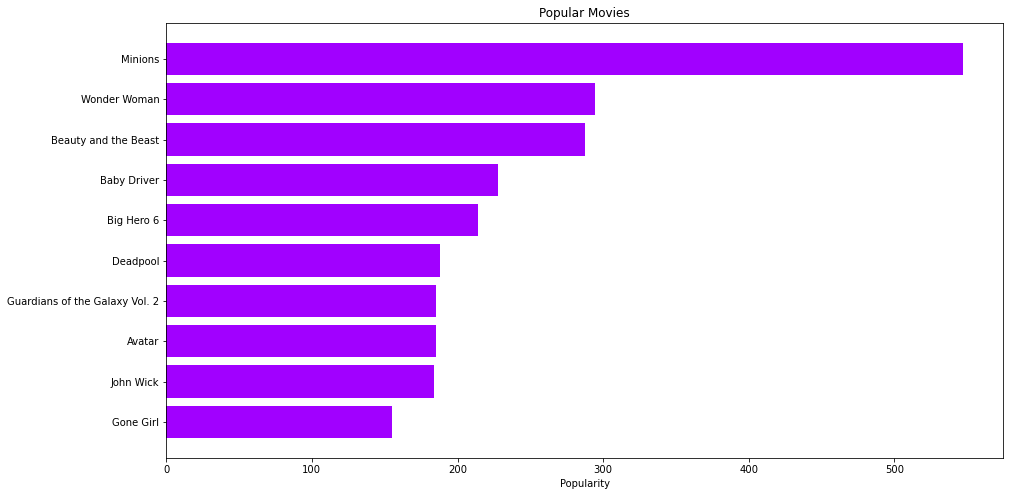

In [108]:
# Create bar plot of most popular movies
pop= movies.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.barh(pop['title'].head(10),pop['popularity'].head(10), align='center',
        color='#a100ff')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

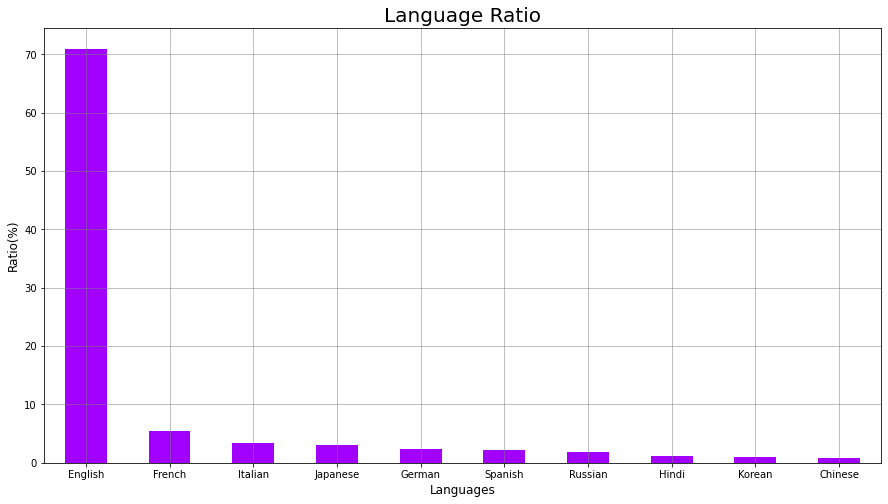

In [109]:
# Create bar plot based on language ratio
plt.figure()
d = meta.original_language.value_counts(normalize=True)[0:10] * 100
ax = d.plot(kind='bar', figsize=(15, 8), rot=0, color='#a100ff')
ax.tick_params(axis='x', labelsize=10, rotation=0);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_xticklabels(["English", "French", "Italian", "Japanese", "German", "Spanish","Russian","Hindi","Korean","Chinese"])
ax.set_ylabel('Ratio(%)', fontsize=12); ax.set_xlabel('Languages', fontsize=12)
ax.set_title('Language Ratio', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

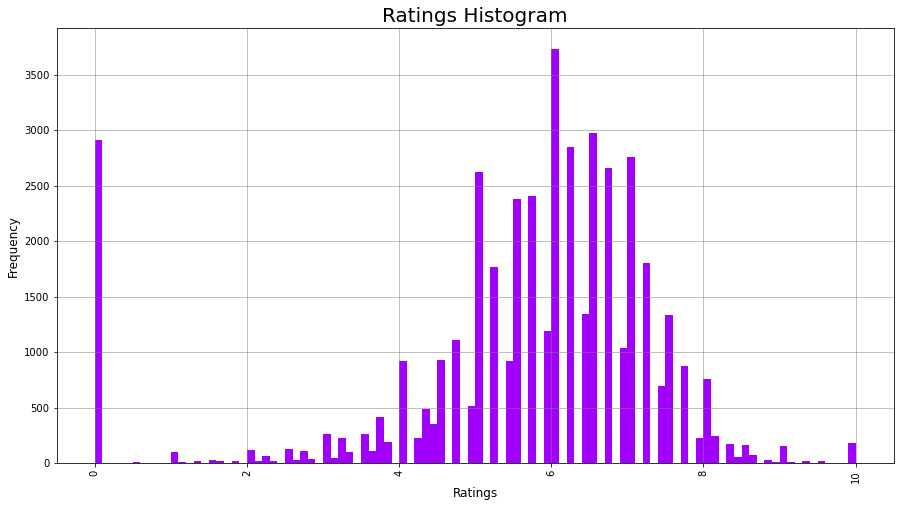

In [110]:
# Create histogram based on ratings
plt.figure()
d = meta.vote_average
ax = d.hist( figsize=(15, 8), bins=100, color='#a100ff')
ax.tick_params(axis='x', labelsize=10, rotation=90);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_ylabel('Frequency', fontsize=12); ax.set_xlabel('Ratings', fontsize=12)
ax.set_title('Ratings Histogram', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

<Figure size 432x288 with 0 Axes>

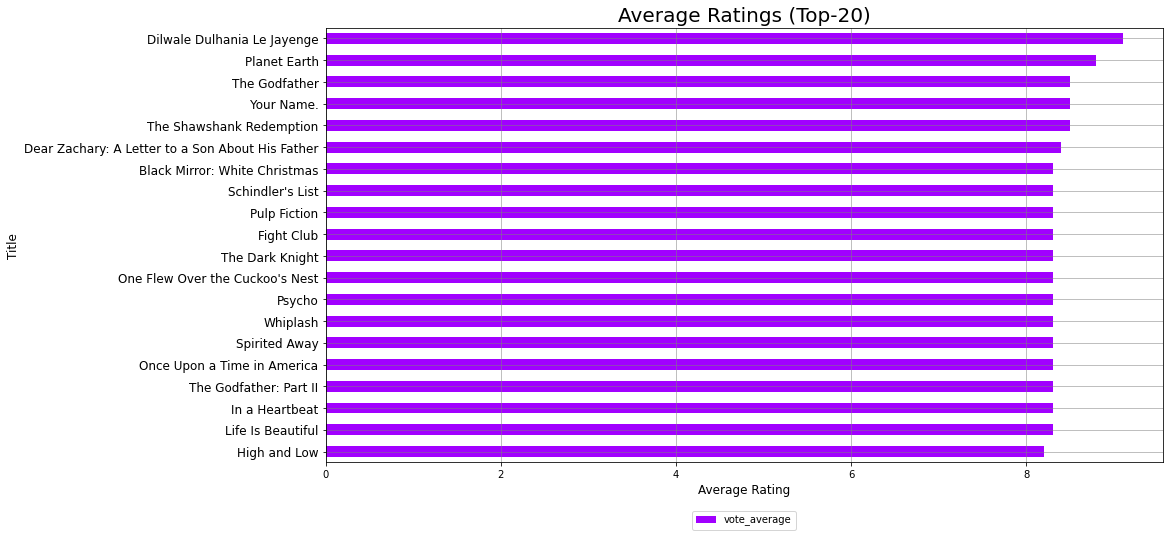

In [111]:
# Create horizontal bar plot for top ratings
count_mean = meta.vote_count.mean()
d = meta.sort_values(by="vote_average", ascending=False).query(f"vote_count > {count_mean}")[0:20]
plt.figure()
ax = d.plot.barh(x="title",y="vote_average", figsize=(15, 8), rot=0, color='#a100ff')
ax.tick_params(axis='y', labelsize=12, rotation=0); ax.tick_params(axis='x', labelsize=10, rotation=0)
ax.set_xlabel('Average Rating', fontsize=12); ax.set_ylabel('Title', fontsize=12)
ax.set_title('Average Ratings (Top-20)', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
ax.invert_yaxis()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
plt.show()

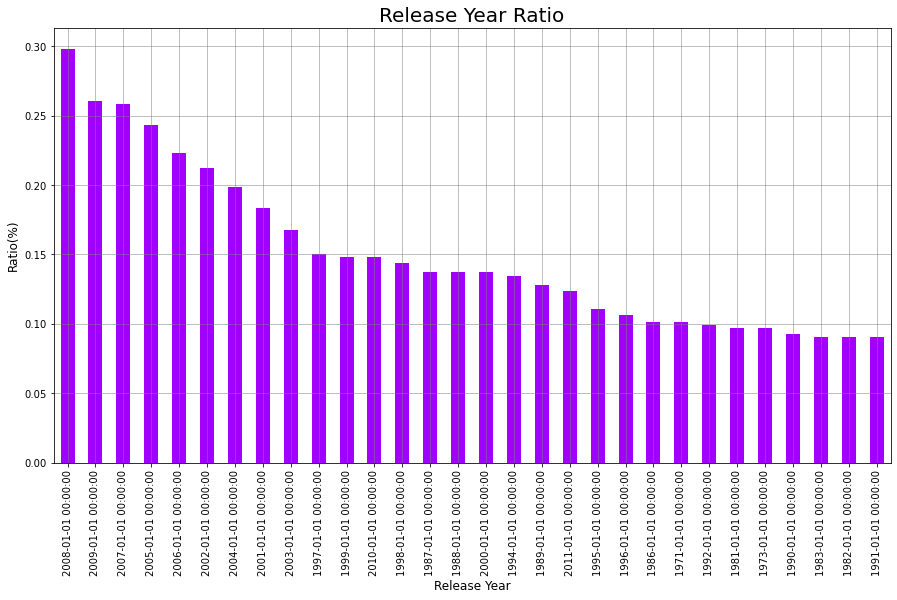

In [112]:
# Create bar plot based on year released
plt.figure()
d = meta.release_date.value_counts(normalize=True)[0:30] * 100
ax = d.plot(kind='bar', figsize=(15, 8), color='#a100ff', rot=0)
ax.tick_params(axis='x', labelsize=10, rotation=90);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_ylabel('Ratio(%)', fontsize=12); ax.set_xlabel('Release Year', fontsize=12)
ax.set_title('Release Year Ratio', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

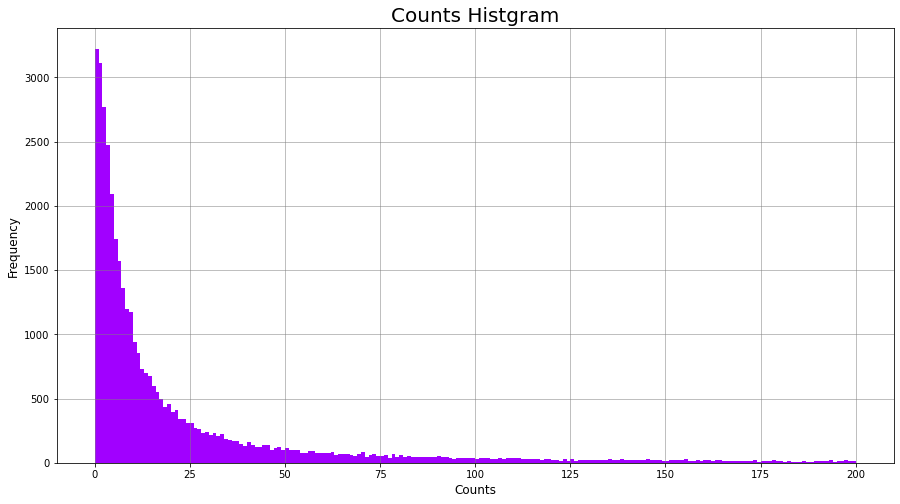

In [113]:
# Create histofram based on counts
plt.figure()
d = meta.vote_count
ax = d.hist( figsize=(15, 8), bins=200,color='#a100ff', range = (0.009, 200))
ax.tick_params(axis='x', labelsize=10);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_ylabel('Frequency', fontsize=12); ax.set_xlabel('Counts', fontsize=12)
ax.set_title('Counts Histgram', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

In [114]:
# Create var that contains list of genres
genres_columns=['Documentary',
       'Western', 'Comedy', 'Family', 'Horror', 'Fantasy', 'Science Fiction',
       'Action', 'Foreign', 'History', 'Drama', 'TV Movie', 'Thriller',
       'Mystery', 'Adventure', 'Romance', 'Animation', 'War', 'Crime', 'Music']

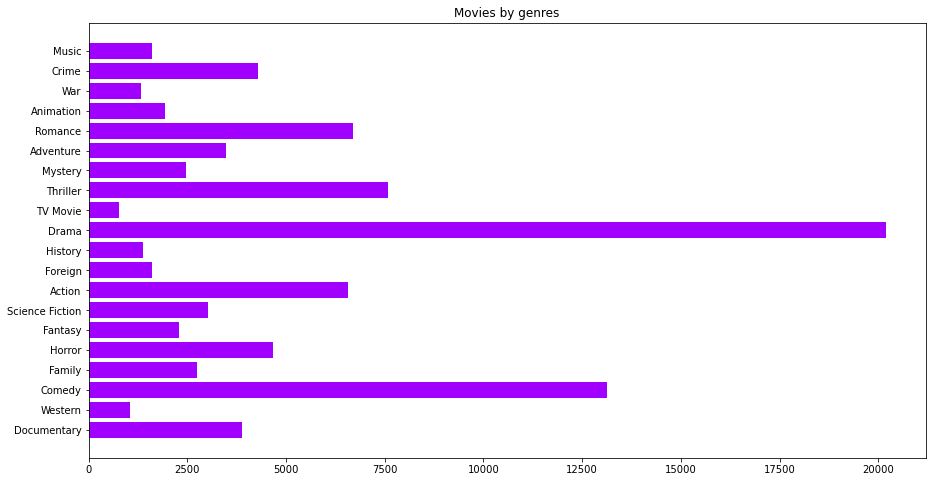

In [115]:
# Plot barplot for genres
names = meta[genres_columns].columns
values = meta[genres_columns].sum().values

fig = plt.figure(figsize = (15, 8) )
 
# creating the bar plot
plt.barh(names, values, color='#a100ff')
 
plt.title("Movies by genres")
plt.show()

### Popular based

                    IMDB Weighted Rank (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

                         R = average for the movie (mean) = (Rating)
                         v = number of votes for the movie = (votes)
                         m = minimum votes required to be listed in the Top 250 
                         C = the mean vote across the whole report 

In [116]:
#Count average vote, and miminum amount of votes that movies should have
vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.97)
print("Average vote:", C)
print("Number of minimum votes:", m)

Average vote: 5.247888723298559
Number of minimum votes: 807.0


In [117]:
#create top_movies df that fits the minumum votes amount and not contains null values
top_movies = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & \
                    (movies['vote_average'].notnull())][['title', 'movieId','release_date', 'vote_count',\
                                                         'vote_average','popularity']]
#change column's types to int
top_movies['vote_count'] = top_movies['vote_count'].astype('int')
top_movies['vote_average'] = top_movies['vote_average'].astype('int')
top_movies

,title,movieId,release_date,vote_count,vote_average,popularity
0,Toy Story,862,1995-10-30,5415,7,21.946943
1,Jumanji,8844,1995-12-15,2413,6,17.015539
5,Heat,949,1995-12-15,1886,7,17.924927
9,GoldenEye,710,1995-11-16,1194,6,14.686036
15,Casino,524,1995-11-22,1343,7,10.137389
...,...,...,...,...,...,...
44872,Despicable Me 3,324852,2017-06-15,2002,6,36.631519
45130,War for the Planet of the Apes,281338,2017-07-11,1675,6,146.161786
45192,Valerian and the City of a Thousand Planets,339964,2017-07-20,905,6,15.262706
45529,Dunkirk,374720,2017-07-19,2712,7,30.938854


                    IMDB Weighted Rank (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

In [118]:
# Create function that rates based on IMDB rating and adds popular points
# Popular points - based on popularity column, is equal from 0 to 1
def IMDB_rating(row):
    max_popular = top_movies['popularity'].max()
    v = row['vote_count']
    R = row['vote_average']
    popular = row['popularity'] / max_popular
    rating = (v / (v + m) * R) + (m / (m + v) * C)
    return rating + popular

In [119]:
%%time
# Apply the function to all rows and create a new rating_top column
top_movies['rating_top'] = top_movies.apply(IMDB_rating, axis=1)
top_movies = top_movies.sort_values('rating_top', ascending=False).head(1000)

CPU times: total: 46.9 ms
Wall time: 45.6 ms


In [120]:
top_movies

,title,movieId,release_date,vote_count,vote_average,popularity,rating_top
12511,The Dark Knight,155,2008-07-16,12269,8,123.167259,8.055118
291,Pulp Fiction,680,1994-09-10,8670,8,140.950236,8.023097
2848,Fight Club,550,1999-10-15,9678,8,63.869599,7.904837
15528,Inception,27205,2010-07-14,14075,8,29.108149,7.903929
22888,Interstellar,157336,2014-11-05,11187,8,32.213481,7.873667
...,...,...,...,...,...,...,...
39046,Money Monster,303858,2016-05-12,1096,6,11.953822,5.702888
12072,Planet Terror,1992,2007-04-06,1109,6,10.370384,5.702160
11112,Babel,1164,2006-09-08,1083,6,12.608530,5.701890
10994,Over the Hedge,7518,2006-04-22,1116,6,9.382953,5.701510


In [121]:
# Function to create list of movies based on popular based
def predict_popular(user_id):
    # Take movieId based on UserID
    list_movies_watched = ratings.loc[ratings["userId"] == user_id, "movieId"]
    movies_recommend = top_movies.copy()
    for movie_id in list_movies_watched:
        # Remove movies that are already watched
        movies_recommend.drop(movies_recommend[movies_recommend['movieId'] == movie_id].index, inplace=True)
    recommend = movies_recommend['title'].head(10)  
    return recommend 

In [122]:
%%time
# Create recommendation
user_popular(1)

NameError: name 'user_popular' is not defined

## Apriori

In [123]:
# Merge the ratings and movies dataframes on the 'movieId' column
movie_ratings = pd.merge(ratings, movies, on='movieId')
movie_ratings

,userId,movieId,rating,timestamp,adult,imdb_id,original_language,original_title,overview,popularity,...,Country2,cast1,cast2,cast3,crew1,crew2,crew3,keyword1,keyword2,keyword3
0,1,1371,5,1260759135,0.0,tt0084602,en,Rocky III,"now the world champion, rocky balboa is living...",11.673366,...,No Country,Sylvester Stallone,Talia Shire,Burt Young,Sylvester Stallone,Sylvester Stallone,Robert Chartoff,transporter,trainer,boxer
1,4,1371,8,949810302,0.0,tt0084602,en,Rocky III,"now the world champion, rocky balboa is living...",11.673366,...,No Country,Sylvester Stallone,Talia Shire,Burt Young,Sylvester Stallone,Sylvester Stallone,Robert Chartoff,transporter,trainer,boxer
2,7,1371,6,851869160,0.0,tt0084602,en,Rocky III,"now the world champion, rocky balboa is living...",11.673366,...,No Country,Sylvester Stallone,Talia Shire,Burt Young,Sylvester Stallone,Sylvester Stallone,Robert Chartoff,transporter,trainer,boxer
3,19,1371,8,855193404,0.0,tt0084602,en,Rocky III,"now the world champion, rocky balboa is living...",11.673366,...,No Country,Sylvester Stallone,Talia Shire,Burt Young,Sylvester Stallone,Sylvester Stallone,Robert Chartoff,transporter,trainer,boxer
4,21,1371,6,853852263,0.0,tt0084602,en,Rocky III,"now the world champion, rocky balboa is living...",11.673366,...,No Country,Sylvester Stallone,Talia Shire,Burt Young,Sylvester Stallone,Sylvester Stallone,Robert Chartoff,transporter,trainer,boxer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44987,652,129009,8,1442690827,0.0,tt0057262,en,Love Is a Ball,etienne makes a good living out of marrying of...,0.875177,...,No Country,Glenn Ford,Hope Lange,Charles Boyer,David Swift,David Swift,Frank Waldman,french riviera,poor,naive girl
44988,653,2103,6,948161066,0.0,tt0307479,en,Solaris,upon arrival at the space station orbiting an ...,10.642824,...,No Country,George Clooney,Natascha McElhone,Viola Davis,Debra Zane,Cliff Martinez,Terri Taylor,clone,loss of sense of reality,hallucination
44989,659,167,8,836137550,0.0,tt0272152,en,K-PAX,prot is a patient at a mental hospital who cla...,12.400152,...,United Kingdom,Jeff Bridges,Kevin Spacey,Mary McCormack,Iain Softley,Lawrence Gordon,Lloyd Levin,robbery,dream,hypnosis
44990,659,563,6,834694187,0.0,tt0120201,en,Starship Troopers,"set in the future, the story follows a young s...",14.412644,...,No Country,Casper Van Dien,Dina Meyer,Denise Richards,Johanna Ray,Harry Cohen,Mark Goldblatt,moon,asteroid,space marine


In [124]:
# Sort the movie_ratings dataframe by 'userId' and 'timestamp' in ascending order
movie_ratings = movie_ratings.sort_values(['userId', 'timestamp'], ascending=[True, False])
movie_ratings

,userId,movieId,rating,timestamp,adult,imdb_id,original_language,original_title,overview,popularity,...,Country2,cast1,cast2,cast3,crew1,crew2,crew3,keyword1,keyword2,keyword3
47,1,1405,2,1260759203,0.0,tt0015881,en,Greed,greed is the classic 1924 silent film by erich...,6.925081,...,No Country,Zasu Pitts,Gibson Gowland,Jean Hersholt,Irving Thalberg,Ernest B. Schoedsack,William H. Daniels,gold,lottery,marriage
140,1,2193,4,1260759198,0.0,tt0085980,en,My Tutor,high school senior bobby chrystal fails his fr...,4.675460,...,No Country,Caren Kaye,Matt Lattanzi,Kevin McCarthy,Mac Ahlberg,Joe Roberts,George Bowers,learning and teaching,tutor,older woman younger man relationship
93,1,2105,8,1260759139,0.0,tt0163651,en,American Pie,"at a high-school party, four friends find that...",18.344227,...,No Country,Jason Biggs,Chris Klein,Thomas Ian Nicholas,Chris Bender,Richard LeGrand Jr.,Priscilla Nedd-Friendly,graduation,innocence,coming of age
0,1,1371,5,1260759135,0.0,tt0084602,en,Rocky III,"now the world champion, rocky balboa is living...",11.673366,...,No Country,Sylvester Stallone,Talia Shire,Burt Young,Sylvester Stallone,Sylvester Stallone,Robert Chartoff,transporter,trainer,boxer
235,1,2455,5,1260759113,0.0,tt0086551,fr,Vivement dimanche!,claude massoulier is murdered while hunting at...,2.672873,...,No Country,Fanny Ardant,Jean-Louis Trintignant,Philippe Laudenbach,François Truffaut,François Truffaut,François Truffaut,detective,clerk,No keyword
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28413,671,2011,7,1063500873,0.0,tt0808417,fr,Persepolis,"in 1970s iran, marjane 'marji' statrapi watche...",9.537501,...,United States of America,Chiara Mastroianni,Danielle Darrieux,Catherine Deneuve,Kathleen Kennedy,Vincent Paronnaud,Vincent Paronnaud,civil war,parent child relationship,1970s
19850,671,2324,8,1063500858,0.0,tt0472126,en,Local Color,a successful artist looks back with loving mem...,1.393391,...,No Country,Armin Mueller-Stahl,Trevor Morgan,Ray Liotta,George Gallo,George Gallo,Jimmy Evangelatos,independent film,No keyword,No keyword
21492,671,2291,10,1063500850,0.0,tt0099871,en,Jacob's Ladder,a traumatized vietnam war veteran finds out th...,8.176863,...,No Country,Tim Robbins,Elizabeth Peña,Danny Aiello,Jeffrey L. Kimball,Tom Rolf,Maurice Jarre,violence,postal worker,figment of imagination
15180,671,1247,8,1063500804,0.0,tt0343737,en,The Good Shepherd,"edward wilson, the only witness to his father'...",11.057536,...,No Country,Matt Damon,Angelina Jolie,Alec Baldwin,Eric Roth,Tariq Anwar,Robert Richardson,london england,berlin,usa


In [125]:
# Group the movie_ratings dataframe by 'userId' and apply the 'list' function to the 'title' column
user_watched_list = movie_ratings.groupby(['userId'])['title'].apply(list).to_list()
user_watched_list

[['Greed',
  'My Tutor',
  'American Pie',
  'Rocky III',
  'Confidentially Yours',
  'Jay and Silent Bob Strike Back'],
 ['La Strada',
  'Not Here to Be Loved',
  'The Marriage of Maria Braun',
  'Fight Club',
  'Catwoman',
  'Wings of Desire',
  'The Last Samurai',
  'True Romance',
  'Pocketful of Miracles',
  'The Green Mile',
  'Love Actually',
  'Bread and Tulips',
  'Berlin: Symphony of a Great City',
  'Monsters, Inc.',
  'My Own Private Idaho',
  'Wag the Dog',
  'The White Sound',
  'Big Fish',
  'Batman Begins',
  'Psycho',
  'The Poseidon Adventure',
  '2001: A Space Odyssey',
  'Rebecca',
  'Reservoir Dogs',
  'Once Were Warriors',
  'Notting Hill',
  'Star Trek IV: The Voyage Home',
  'A Nightmare on Elm Street',
  'Lili Marleen',
  'The Devil Wears Prada',
  'The Dark',
  'Cat on a Hot Tin Roof',
  'Lucky Number Slevin',
  'Stand by Me',
  'Monsoon Wedding',
  'Batman Returns',
  'Romeo + Juliet',
  'Contempt',
  'Man of Iron',
  'Grbavica: The Land of My Dreams',
  'Thr

In [126]:
# Apply the apriori function to the user_watched_list with the specified parameters
rules = apriori(user_watched_list, min_support=0.003, min_confidence=0.2, min_lift=3, min_length=2, max_length=2)

In [127]:
# Convert the rules object to a list and store it in the 'results' variable
results = list(rules)

# Print the total number of rules
print(f"Total rules: {len(results)}")

Total rules: 221896


In [128]:
# Create a dataframe from the 'results' list
df_results = pd.DataFrame(results)
df_results

,items,support,ordered_statistics
0,"(3-Iron, 10 Items or Less)",0.004471,"[((10 Items or Less), (3-Iron), 0.272727272727..."
1,"(10 Items or Less, 300)",0.004471,"[((10 Items or Less), (300), 0.272727272727272..."
2,"(8 Women, 10 Items or Less)",0.004471,"[((10 Items or Less), (8 Women), 0.27272727272..."
3,"(10 Items or Less, 88 Minutes)",0.004471,"[((10 Items or Less), (88 Minutes), 0.27272727..."
4,"(A Bridge Too Far, 10 Items or Less)",0.010432,"[((10 Items or Less), (A Bridge Too Far), 0.63..."
...,...,...,...
221891,"(Zatoichi, Zodiac)",0.004471,"[((Zodiac), (Zatoichi), 0.3, 3.3)]"
221892,"(eXistenZ, Zatoichi)",0.011923,"[((eXistenZ), (Zatoichi), 0.6666666666666666, ..."
221893,"(À nos amours, Zatoichi)",0.007452,"[((À nos amours), (Zatoichi), 0.35714285714285..."
221894,"(xXx, Zatôichi's Pilgrimage)",0.004471,"[((Zatôichi's Pilgrimage), (xXx), 1.0, 23.9642..."


In [129]:
# Extract the 'support', 'ordered_statistics' columns from the df_results dataframe
support = df_results['support']
ordered_statistics = df_results['ordered_statistics']

In [130]:
# Create empty lists to store the values for the 'lhs', 'rhs', 'confidence', and 'lift' columns
lhs = []
rhs = []
confidence = []
lift = []

In [131]:
# Iterate over the ordered_statistics column and extract the values for the 'lhs', 'rhs', 'confidence', and 'lift' columns
for i in ordered_statistics:
    lhs.append(list(i[0][0]))
    rhs.append(list(i[0][1]))
    confidence.append(i[0][2])
    lift.append(i[0][3])

In [132]:
# Create dataframes for the 'lhs', 'rhs', 'confidence', and 'lift' columns
df_lhs = pd.DataFrame(lhs, columns=['Movie1'])
df_rhs = pd.DataFrame(rhs, columns=['Movie2'])
df_confidence = pd.DataFrame(confidence, columns=['confidence'])
df_lift = pd.DataFrame(lift, columns=['lift'])

In [133]:
# Concatenate the 'lhs', 'rhs', 'support', 'confidence', and 'lift' dataframes into a single dataframe
df_final_apriori = pd.concat([df_lhs, df_rhs, support, df_confidence, df_lift], axis=1)

In [134]:
# Sort the df_final dataframe by the 'lift' column in descending order
df_final_apriori = df_final_apriori.sort_values('lift', ascending=False)

# Display the top 10 rows of the df_final dataframe
df_final_apriori.head(10)

,Movie1,Movie2,support,confidence,lift
146705,Land of Plenty,The Astronaut's Wife,0.004471,1.00,223.666667
178543,Pather Panchali,Return to Me,0.004471,1.00,167.750000
56321,Blow,Erreur de la banque en votre faveur,0.004471,1.00,167.750000
176940,Oscar,The Astronaut's Wife,0.004471,0.75,167.750000
24004,Alvin and the Chipmunks,Freddy vs. Jason,0.004471,1.00,167.750000
140481,Judex,The Pebble and the Penguin,0.004471,0.75,167.750000
146671,Land of Plenty,Oscar,0.004471,1.00,167.750000
46670,Bella Bettien,The Enforcer,0.005961,1.00,167.750000
127960,Hiroshima Mon Amour,Shooting War,0.004471,1.00,134.200000
127959,Hiroshima Mon Amour,Seabiscuit,0.004471,1.00,134.200000


In [135]:
def last_movie_watched(user_id):
    """
    Returns the last movie watched by the specified user.
    """
    last_movie_watched = movie_ratings.loc[movie_ratings["userId"] == user_id, "title"].iloc[0]
    return last_movie_watched

def predict_apriori(user_id):
    """
    Predicts the next movie to watch for the specified user using the apriori algorithm.
    """
    # Get a list of movies watched by the user
    movies_watched = movie_ratings.loc[movie_ratings["userId"] == user_id, "title"].tolist()
    # Get the last movie watched by the user
    last_movie_watched_user = last_movie_watched(user_id)
    # Get a list of movies recommended based on the last movie watched
    movies_recommended = df_final_apriori.loc[df_final_apriori['Movie1'] == last_movie_watched_user, \
                                              "Movie2"].tolist()
    # Remove movies that have already been watched by the user
    movies_recommended = [movie for movie in movies_recommended if movie not in movies_watched]
    # Return the top 10 recommended movies
    return movies_recommended[:10]

In [136]:
last_movie_watched(1)

'Greed'

In [137]:
predict_apriori(1)

['Killing Zoe',
 'The 40 Year Old Virgin',
 'Saw',
 'Walk the Line',
 'The War of the Gargantuas',
 'Taxi 4',
 'Human Nature',
 'That Most Important Thing: Love',
 'Minority Report',
 "Summer '04"]

## Surprise SVD

In [138]:
# Load data
ratings_SVD = ratings.drop(columns="timestamp")
reader = surprise.Reader(rating_scale=(1, 10))
train_set = surprise.Dataset.load_from_df(ratings_SVD, reader=reader).build_full_trainset()

In [139]:
# Train model
svd = surprise.SVD(n_factors=200, n_epochs=30, verbose=True)
with Timer() as train_time:
    svd.fit(train_set)
print(f"Training took {train_time.interval} seconds.")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Training took 11.971000699999998 seconds.


In [140]:
# Make predictions
predictions = predict(svd, ratings_SVD, usercol='userId', itemcol='movieId')
predictions

,userId,movieId,prediction
0,1,31,4.809544
1,1,1029,5.461237
2,1,1061,5.744443
3,1,1129,4.498070
4,1,1172,7.590103
...,...,...,...
99999,671,6268,5.335429
100000,671,6269,7.991477
100001,671,6365,7.617758
100002,671,6385,6.060068


In [141]:
# Compute ranking predictions
with Timer() as test_time:
    ranking_predictions = compute_ranking_predictions(svd, ratings_SVD, usercol='userId', itemcol='movieId', remove_seen=True)
print(f"Prediction took {test_time.interval} seconds.")

Prediction took 39.026319400000006 seconds.


In [142]:
# Merge and sort predictions
title_id = movies[['movieId','title']]
ranking_predictions = pd.merge(ranking_predictions, title_id, on='movieId', how='inner')
ranking_predictions = ranking_predictions.sort_values(['userId', 'prediction'], ascending = [True, False])

In [143]:
# Function to return top 10 movie recommendations for a given user
def predict_SVD(user_id):
    list_movies_watched = movie_ratings.loc[movie_ratings["userId"] == user_id, "movieId"]
    movies_recommend = ranking_predictions.loc[ranking_predictions['userId']==user_id]

    for movieId in list_movies_watched:
        # remove movies that are already watched
        movies_recommend = movies_recommend[movies_recommend.movieId != movieId]
        
    # Convert the title column to a list and return the first 10 elements
    return list(movies_recommend.title[:10])

In [144]:
%%time
# Get top 10 movie recommendations for user 1
predict_SVD(1)

CPU times: total: 46.9 ms
Wall time: 4.81 ms


['Cousin, Cousine',
 'The Million Dollar Hotel',
 'Solaris',
 'Edward Scissorhands',
 'The Ewok Adventure',
 'Beetlejuice',
 'Children of the Corn IV: The Gathering',
 'Fools Rush In',
 'Boogie Nights',
 'Terminator 3: Rise of the Machines']

## Cosine similarity (based on overview)

In [146]:
# Create plots and transform them using vectorizer
plots = movies['overview']
tfidf = TfidfVectorizer(stop_words='english', max_df=4, min_df=1)
plots = plots.fillna('')
tfidf_matrix = tfidf.fit_transform(plots)

In [147]:
# Calculate cosine similarity
cos_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [148]:
# Create indices without duplicates
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [149]:
# Function to return list of movies based on movie title
def predict_by_overview(title):
    idx = indices[title]
    similar = list(enumerate(cos_similarity[idx]))
    similar = sorted(similar, key=lambda x: x[1], reverse=True)
    similar = similar[:11]
    movie_indices = []
    for i in similar:
        movie_indices.append(i[0])
    return list(movies['title'].iloc[movie_indices])

In [150]:
predict_by_overview("Avatar")

['Toy Story',
 'Jumanji',
 'Grumpier Old Men',
 'Waiting to Exhale',
 'Father of the Bride Part II',
 'Heat',
 'Sabrina',
 'Tom and Huck',
 'Sudden Death',
 'GoldenEye',
 'The American President']

## Markov chains

In [174]:
# Create a dataframe with needed columns
markov_df = movie_ratings[['userId', 'movieId', 'rating', 'timestamp', 'title']]
markov_df

,userId,movieId,rating,timestamp,title
47,1,1405,2,1260759203,Greed
140,1,2193,4,1260759198,My Tutor
93,1,2105,8,1260759139,American Pie
0,1,1371,5,1260759135,Rocky III
235,1,2455,5,1260759113,Confidentially Yours
...,...,...,...,...,...
28413,671,2011,7,1063500873,Persepolis
19850,671,2324,8,1063500858,Local Color
21492,671,2291,10,1063500850,Jacob's Ladder
15180,671,1247,8,1063500804,The Good Shepherd


In [175]:
# Sort the dataframe by user id and timestamp
markov_df = markov_df.sort_values(by=['userId', 'timestamp'])
markov_df

,userId,movieId,rating,timestamp,title
182,1,2294,4,1260759108,Jay and Silent Bob Strike Back
235,1,2455,5,1260759113,Confidentially Yours
0,1,1371,5,1260759135,Rocky III
93,1,2105,8,1260759139,American Pie
140,1,2193,4,1260759198,My Tutor
...,...,...,...,...,...
26428,671,1266,8,1065149270,Street Kings
5757,671,590,8,1065149296,The Hours
10356,671,919,8,1065149458,Blood: The Last Vampire
5555,671,588,8,1065149478,Silent Hill


In [176]:
# Group the dataframe by user id and create a list of movies for each user
def create_movie_sequence(df):
    return list(df['title'])
markov_df = markov_df.groupby('userId').apply(create_movie_sequence)
markov_df

userId
1      [Jay and Silent Bob Strike Back, Confidentiall...
2      [48 Hrs., Terminator 3: Rise of the Machines, ...
3      [300, The Killing, Shortbus, Finding Neverland...
4      [David, The Wedding Planner, Casablanca, Sleep...
5      [Gleaming the Cube, Cool Hand Luke, Hidalgo, U...
                             ...                        
667    [The Hours, 48 Hrs., Terminator 3: Rise of the...
668    [The Believer, The Talented Mr. Ripley, Local ...
669    [The 39 Steps, The Other Side of the Bed, Mons...
670    [American Pie 2, The Million Dollar Hotel, 48 ...
671    [Reign Over Me, The Good Shepherd, Jacob's Lad...
Length: 671, dtype: object

In [177]:
#create a sequence of reviewed movies as a list
list_movies_sequences = []
for user_sequence in markov_df.values:
    for i in range(len(user_sequence)-1):
        list_movies_sequences.append([user_sequence[i], user_sequence[i+1]])

In [178]:
# Transform the list of movie sequences into a dataframe
markov_df_final = pd.DataFrame(data=list_movies_sequences, columns=('movie1', 'movie2'))

In [179]:
# Remove duplicates to keep only unique sequences
markov_df_final = markov_df_final.drop_duplicates()

In [180]:
# Function to calculate the probability of a movie sequence
def find_probability(x):
    movie1 = x['movie1']
    movie2 = x['movie2']
    total_movies = 0  # total number of sequences from movie x to any movie
    number = 0  # number of sequences from movies x to movie y
    for item in list_movies_sequences:  # loop through all sequences
        if (item[0] == movie1 and item[1] == movie2):
            number += 1
        if (item[0] == movie1):
            total_movies += 1
    result = number / total_movies
    return result

In [181]:
#apply the function to all rows to create new column
markov_df_final['probability'] = markov_df_final.apply(find_probability, axis=1)

In [182]:
markov_df_final = markov_df_final.sort_values('probability', ascending = False)

In [183]:
def predict_markov(userId):
    movieTitle = movie_ratings.loc[movie_ratings["userId"] == userId, "title"]
    movieTitle = movieTitle.iloc[0]
    list_of_movies = markov_df_final.loc[markov_df_final["movie1"] == movieTitle, "movie2"].head(10)
    
    return list_of_movies

In [184]:
predict_markov(1)

10567                     Ali: Fear Eats the Soul
9925     Harry Potter and the Philosopher's Stone
700                                     Malcolm X
4423                                        Krull
40595                              28 Weeks Later
28780       The Mummy: Tomb of the Dragon Emperor
17513                                Spider-Man 2
19909                                Donnie Darko
287                            The Endless Summer
24355                             Monsoon Wedding
Name: movie2, dtype: object

In [190]:
last_movie_watched(1)

'Greed'

In [187]:
def recommendation(user_id):
    movies_watched = movie_ratings.loc[movie_ratings["userId"] == user_id, "title"].count()
    if (movies_watched<10):
        return predict_popular(user_id)
    else:
        return predict_markov(user_id)

In [192]:
last_movie_watched(35)

'Kill Bill: Vol. 1'

In [188]:
recommendation(35)

6345                  Asterix at the Olympic Games
12658                             Addicted to Love
7857                                   Bring It On
43665                                 Lili Marleen
13408                                       Hitman
32709                                     Big Fish
43387                                    Spanglish
43543                           Young and Innocent
25565    Women on the Verge of a Nervous Breakdown
42263                                     Rain Man
Name: movie2, dtype: object

In [189]:
recommendation(1)

12511                                      The Dark Knight
291                                           Pulp Fiction
2848                                            Fight Club
15528                                            Inception
22888                                         Interstellar
313                               The Shawshank Redemption
350                                           Forrest Gump
4871     The Lord of the Rings: The Fellowship of the Ring
7018         The Lord of the Rings: The Return of the King
5831                 The Lord of the Rings: The Two Towers
Name: title, dtype: object